In [1]:
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import h5py
from os.path import isfile, join
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from bispectrumcode.python.scrappystuff.bispectrum_tricky import *
import sklearn.decomposition
from spykes.plot.neurovis import NeuroVis
from spykes.plot.popvis import PopVis
from spykes.io.datasets import load_reward_data

# Utils

### Data wrangling

In [3]:
def load_data(data_dir, num_frames=None, num_neurons=None, ds=True):
    files = [f for f in os.listdir(data_dir) if isfile(join(data_dir, f)) and f[-3:]=='mat']
    spike_count = []
    stim = {}
    neuron = []
    for i, f in enumerate(files[:num_neurons]):
        loaded = h5py.File(data_dir+f,'r')
        num = f[3:6]
        spikes = np.array(loaded['psths']).tolist()[0][:num_frames]
        spike_count += [x for x in spikes]
        vid = np.array(loaded['rawStims'], dtype=np.float32)[:num_frames]
        vid = np.transpose(vid, axes=[0,2,1])
        vid = (vid.transpose() - np.mean(vid, axis=(1,2))).transpose()
        if ds:
            vid = downsample(vid)
        stim[num] = vid
        neuron += [num] * len(vid)
    data = pd.DataFrame({'neuron': neuron, 'spike_count': spike_count})
    return data, stim

In [2]:
def downsample(data, ds_factor=2):
    ds = np.zeros((len(data), int(data.shape[1]/ds_factor), int(data.shape[2]/ds_factor)))
    for idx, img in enumerate(data):
        new_img = np.zeros((img.shape[0] / ds_factor, img.shape[1] / ds_factor))
        for i in range(new_img.shape[0]):
            for j in range(new_img.shape[1]):
                patch = img[i*ds_factor:(i+1)*ds_factor, j*ds_factor:(j+1)*ds_factor]
                new_img[i, j] = np.mean(patch)
            ds[idx] = new_img
    return ds

### Plotting

In [4]:
def show_stim(neuron, df, n_frames=100):
    
    def init():
        return (im,)
    
    def animate(frame):
        im.set_data(frame)
        return (im,)
    
    vid = stim[neuron][:n_frames]
    fig, ax = plt.subplots()
    im = ax.imshow(np.zeros(vid[0].shape), vmin=np.min(vid), vmax=np.max(vid), cmap='Greys_r');
    plt.axis('off')
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=vid, interval=12.5, blit=True)
    plt.close()
    return HTML(anim.to_html5_video())

In [5]:
def plot_spike_counts(neuron, data, num_frames=100):
    plt.bar(x=range(num_frames), height=data[data['neuron']=='058'].spike_count[:num_frames])

In [12]:
def raster_plot(data, num_neurons, num_frames):
    raster = np.zeros((num_neurons, num_frames))
    for i, n in enumerate(data.neuron.unique()[:num_neurons]):
        raster[i] = data[data.neuron==n].spike_count[:num_frames]
    return raster

### Analysis

In [199]:
def PCA_reduction(data, method='orthogonal', n_components=100):
    means = data.mean(axis=(1))[:,None]
    data -= means
    C = np.cov(data.T)
    U, S, V = np.linalg.svd(C)
    S = 1/np.sqrt(S + 1e-6)
    S = np.diag(S)
    U = U[:, :n_components]
    reduced = np.matmul(data, U)
    return reduced

In [200]:
def compute_spectra(stim, n_components=100):
    power_spectrum = {}
    bispec = {}
    power_spectrum_reduced = {}
    bispectrum_reduced = {}
    pca = {}
    for neuron in stim.keys():
        vid_power_spectrum = np.zeros(stim[neuron].shape)
        vid_bispectrum = []
        vid_pca = []
        for i, img in enumerate(stim[neuron]):
            img_fourier = np.fft.fft2(img, img.shape)
            img_power_spectrum = img_fourier * np.conj(img_fourier)
            img_pca = PCA_reduction(img, n_components)
            vid_power_spectrum[i] = img_power_spectrum
            vid_bispectrum.append(bispectrum(img_fourier, truncated=True))
            vid_pca.append(img_pca)
        vid_power_spectrum = np.reshape(vid_power_spectrum, (vid_power_spectrum.shape[0], vid_power_spectrum.shape[1] * vid_power_spectrum.shape[2]))
        vid_bispectrum = np.asarray(vid_bispectrum)
        vid_bispectrum = np.reshape(vid_bispectrum, (vid_bispectrum.shape[0], vid_bispectrum.shape[1] * vid_bispectrum.shape[2]))
        power_spectrum[neuron] = vid_power_spectrum
        bispec[neuron] = vid_bispectrum
        bispectrum_reduced[neuron] = PCA_reduction(vid_bispectrum, n_components)
        power_spectrum_reduced[neuron] = PCA_reduction(vid_power_spectrum, n_components)
        pca[neuron]= vid_pca
    return power_spectrum, power_spectrum_reduced, bispec, bispectrum_reduced, pca

# Perform analyses

In [6]:
data_dir = 'data/mt-2/'
num_neurons = 10
num_frames = 100

In [7]:
data, stim = load_data(data_dir, num_frames, num_neurons, ds=True)

In [13]:
raster = raster_plot(data, num_neurons, num_frames)

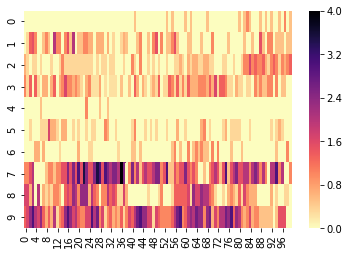

In [14]:
import seaborn as sns
sns.heatmap(raster, cmap="magma_r")

In [15]:
example_neuron = '058'

In [16]:
show_stim(example_neuron, stim, 100)

In [ ]:
ps, psr, bs, bsr, pca = compute_spectra(stim)

/Users/Sophia/Software/anaconda3/envs/gbs/lib/python2.7/site-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
